## MNIST Data

Full classification of MNIST data.

The original MNIST dataset is used.

In the following, we use the following notation (see also the notations sheet):

m: Number of samples <br>
n: Number of features

### Data Preparation

#### Load Data 

Image Data Shape (70000, 784)
Label Data Shape (70000,)
[[  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0   0   0  22 183 252 254 252 252
  252  76   0   0   0   0   0   0   0   0]
 [  0   0   0   0   0   0   0   0   0   0  85  85 168 250 250 252 250 250
  250 250  71   0  43  85  14   0   0   0]
 [  0   0   0   0   0   0   0   0   0 107 252 250 250 250 250 252 250 250
  250 250 210   0 127 250 146   0   0   0]
 [  0   0   0   0   0   0   0   0 114 237 252 250 250 250 250 252 250 250
  250 250 210   0 127 250 250   0   0   0]
 [  0   

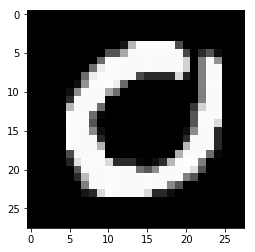

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import fetch_mldata
mnist = fetch_mldata('MNIST original')
x, y = mnist['data'], np.array(mnist['target'], dtype='int')

print("Image Data Shape" , x.shape)
print("Label Data Shape", y.shape)

image = x[17,:]
plt.imshow(np.reshape(image, (28,28)), cmap=plt.cm.gray)
print(np.reshape(image, (28,28)))
print(y[17])

#### Split Data and bring it in the correct shape

Split the data into training set and test set.
We use the scikit-learn function 'train_test_split' and use 10'000 test samples (~14%).

Furthermore, we bring the input data (x) into the shape (n,m) where n is the number of input features and m the number of samples.  

In [2]:
from sklearn.model_selection import train_test_split

# split
x_train0, x_test0, y_train, y_test = train_test_split(x, y, test_size=10000, random_state=0)

# reshape: 
# for x a simple transpose is sufficient 
# (m,n) -> (n,m) where m is the number of samples and n the number of input features (pixels)
# for y reshape the simple array to become a (1,m) array
x_train1 = x_train0.T
x_test1 = x_test0.T
m_train = x_train0.shape[0]
m_test = x_test0.shape[0]
y_train=y_train.reshape(1,m_train)
y_test=y_test.reshape(1,m_test)

print("Shape training set: ", x_train1.shape, y_train.shape)
print("Shape test set:     ", x_test1.shape, y_test.shape)

Shape training set:  (784, 60000) (1, 60000)
Shape test set:      (784, 10000) (1, 10000)


#### Data Normalisation

Rescale the data - apply min/max rescaling (- we get back to centering later).

Test that the result is expected.

In [3]:
import numpy as np
xmax = np.max(x_train1)
xmin = np.min(x_train1)
print(xmin, xmax)
x_train = x_train1 / xmax
x_test = x_test1 / xmax

0 255


### Softmax

In [4]:
def softmax(z):
    z -= np.max(z)
    sm = (np.exp(z).T / np.sum(np.exp(z),axis=1)).T
    return sm

def predict(W, b, X):
    '''
    Compute the per class probabilities for all the m samples by using a softmax layer with parameters (W, b).
    
    Arguments:
    W -- weights, a numpy array with shape (ny, nx) (with ny=10 for MNIST).
    b -- biases, a numpy array with shape (ny,1)
    X -- input data of size (nx,m) or (nx,1)
    
    Returns:
    A -- a numpy array of shape (ny,m) or (ny,1) with the prediction probabilities for the digits.
    ''' 
    ### START YOUR CODE ###
    A = softmax(np.dot(X.T, W.T)+b.T)
    ### END YOUR CODE ###
    return A.T
 

#### TEST Softmax

In [5]:
W = np.array([[1,-1],[0,1],[-1,1]]).reshape(3,2)
b = np.array([0,0,0]).reshape(3,1)
X = np.array([2, 3]).reshape(2,1)
A = predict(W,b,X)
Aexp = np.array([0.01587624,0.86681333,0.11731043]).reshape(A.shape)
np.testing.assert_array_almost_equal(A,Aexp,decimal=8)
np.testing.assert_array_almost_equal(np.sum(A, axis=0), 1.0, decimal=8)

X = np.array([[2,-1,1,-1],[1,1,1,1]]).reshape(2,4)
A = predict(W,b,X)
Aexp = np.array([[0.46831053, 0.01321289, 0.21194156, 0.01321289],
 [0.46831053, 0.26538793, 0.57611688, 0.26538793],
 [0.06337894, 0.72139918, 0.21194156, 0.72139918]]
)
np.testing.assert_array_almost_equal(A,Aexp,decimal=8)
np.testing.assert_array_almost_equal(np.sum(A, axis=0), np.ones(4,dtype='float'), decimal=8)

### Cost Function (Cross Entropy)


In [6]:
def reshapey(yhat,y):
    """
    Checks whether the inputs come as a list in which case it reshapes it to (1,m).
    Implementation is sloppy...
    """
    if type(yhat).__module__ == np.__name__:
        m = yhat.size
        yhat = yhat.reshape(1,m)
        y = y.reshape(1,m)
    else:
        m = 1
    return yhat, y, m

In [7]:
def cost(Ypred, Y):
    """
    Computes the cross entropy cost function for given predicted values and labels.
    
    Parameters:
    Ypred -- prediction from softmax, a numpy array of shape (ny,m) or (ny,1)
    Y -- output labels - a numpy array with shape (1,m) or a scalar.
    
    Returns:
    Cross Entropy Cost
    """
    ### START YOUR CODE ###
    m = len(Y)
    
    # see cost function on slide 13
    #Select the right index.
    # The idea is, Y represents the right label, for the secon example the labels are 1, 1, 1, 0
    # ypred is (rounded 2 decimals) [[0.02 0.01 0.05 1.  ]
    #                                [0.98 0.99 0.95 0.  ]]
    # which means that for the first h the % that it is a zero is 2% and that it is a 1 is 98%
    # now you select the value from your Y value meaning 0.98, 0.99, 0.95, 1  with Ypred.T[np.arange(m), Y]
    ### END YOUR CODE ###
    return - (np.log(Ypred.T[np.arange(m), Y]).mean())
    

#### TEST Cross Entropy Cost 

In [8]:
Y = np.array([1])
Ypred = np.array([0.04742587,0.95257413]).reshape(2,1)
J = cost(Ypred,Y)
Jexp = 0.04858735
np.testing.assert_almost_equal(J,Jexp,decimal=8)
print('second test')
Y = np.array([1,1,1,0])
Ypred = np.array([[1.79862100e-02, 6.69285092e-03, 4.74258732e-02, 9.99088949e-01],
                  [9.82013790e-01, 9.93307149e-01, 9.52574127e-01, 9.11051194e-04]])
print(np.round(Ypred, 2))
Jexp = 0.01859102
J = cost(Ypred,Y)
np.testing.assert_almost_equal(J,Jexp,decimal=8)

second test
[[0.02 0.01 0.05 1.  ]
 [0.98 0.99 0.95 0.  ]]


### Update Rules for the Parameters

Different update rules associated with the different cost functions.

In [9]:
def onehot(y,n):
    """
    Constructs a one-hot-vector from a given array of labels (shape (1,m)) and the number of classes n.
    The resulting array has shape (n,m) and in row j and column i a '1' if the i-th sample had a label 'j'.
    We assume that the labels can have values (0,1,2,...,n-1). 
    """
    m = y.shape[1]
    result = np.zeros((n,m),dtype=float)
    result[y[0,:],np.arange(m)] = 1
    return result

In [10]:
def gradient(W, b, X, Y):
    """
    Computes the update of the weights and bias - by using the cross entropy cost. 
    
    Arguments:
    W -- weights, a numpy array of size (ny,nx)
    b -- biases, a numpy array with shape (ny,1) (ny=10 for MNIST).
    X -- input data of size (nx,m) or (nx,1)
    Y -- output labels - a numpy array with shape (1,m).

    Returns:
    gradJ -- dictionary with the gradient w.r.t. W (key "dW" with shape (ny,nx)) and w.r.t. b (key "db" with shape (ny,1))
    """
    ### START YOUR CODE ###   
    m = Y.shape[1]
    n = W.shape[0]
    
    yhat = predict(W, b, X)
    one_hot = onehot(Y, n)
    
    gradJ = {}
    gradJ['dW'] = -1/m * np.dot((one_hot - yhat), X.T)
    gradJ['db'] = -1/m * np.sum((one_hot - yhat), axis=1).reshape(b.shape)
    ### END YOUR CODE ###
    return gradJ
    

#### Test the Calculation of the Gradient

In [11]:
W = np.array([[1,-1],[0,1],[-1,1]]).reshape(3,2)
b = np.array([0,0,0]).reshape(3,1)
X = np.array([[2,-1,1,-1],[1,1,1,1]]).reshape(2,4)
Y = np.array([1,1,1,1]).reshape(1,4)
gradJ = gradient(W,b,X,Y)
dW = gradJ['dW']
db = gradJ['db']
dWexp = np.array([[ 0.28053421,0.17666947],
                  [-0.00450948,-0.60619918],
                  [-0.27602473,0.42952972]]).reshape(3,2)
dbexp = np.array([0.17666947,-0.60619918,0.42952972]).reshape(3,1)
np.testing.assert_array_almost_equal(dW,dWexp,decimal=8)
np.testing.assert_array_almost_equal(db,dbexp, decimal=8)

### For the Output Analysis 

In [12]:
def error_rate(Ypred, Y):
    """
    Compute the error rate defined as the fraction of misclassified samples.
    
    Arguments:
    W -- weights, a numpy array of size (ny,nx)
    b -- biases, a numpy array with shape (ny,1) (with ny=10 for MNIST).
    X -- input data of size (nx,m) or (nx,1)
    Y -- output labels - a numpy array with shape (1,m) or a scalar.

    Returns:
    error_rate 
    """
    Ypredargmax = np.argmax(Ypred, axis=0)
    return np.sum(Y != Ypredargmax) / Y.size

In [13]:
import numpy as np 
import matplotlib.pyplot as plt
%matplotlib inline

PIXELS = (28,28)
COLS = 5
def plot_digits(X,Y,indices):
    """
    Plots the digits in a mosaic with up to 8 columns

    Arguments:
    X -- data of size (1, 64)
    Y -- label (a scalar)
    indices -- list of indices    
    """
    if len(indices)==0:
        print("No images to show!")
        return
    cols = min(COLS, len(indices))
    rows = len(indices)/COLS+1
    plt.figure(figsize=(20,5*rows))
    for index, (image, label) in enumerate(zip(X.T[indices,:], Y.T[indices,:])):
        plt.subplot(rows, cols, index+1)
        plt.imshow(np.reshape(image, PIXELS), cmap=plt.cm.gray)
        plt.title('Sample %i\n Label %i\n' % (indices[index],label), fontsize = 12)

### Initialize and Optimize (Learn)

#### Initialize Parameters

In [14]:
def initialize_params(nx,ny, random=False):
    """
    This function creates initial values:
    * for w a vector of zeros of shape (1,n) [random=False] or a vector of normally distributed random values [random=True] 
    * for b set to 0.
    
    Argument:
    nx,ny -- number of input features and number of outputs

    Returns:
    W -- initialized weights matrix of shape (ny,nx)
    b -- initialized bias array of shape (ny,1)
    """
    if random:
        W = np.random.randn(*(ny,nx))
    else:
        W = np.zeros((ny,nx))
    b = np.zeros((ny,1))
    
    return W, b

#### Optimisation

In [15]:
def optimize(W, b, x_train, y_train, x_test, y_test, nepochs, alpha):
    """
    This function optimizes w and b by running (batch) gradient descent. It starts with the given 
    weights as initial values and then iteratively updates the parameters for nepochs number of times.
    Returns the trained parameters values as dictionary (keys "w" and "b") and various quantities 
    collected during learning also as dictionary: cost on train and test set ("cost_train", "cost_test"), 
    error rate on train and test set ("error_train", "error_test"), learning speed as length of dw and db
    multiplied by alpha with key "step_w" and "step_b", respectively.
    The output is provided in form of dictionaries (basically, to avoid handling too many variable names in 
    functional calls).
    
    Arguments:
    W -- weights, a numpy array of size (ny,nx)
    b -- biases, a numpy array with shape (ny,1) (with ny=10 for MNIST).
    X -- input data of size (nx,m) or (nx,1)
    Y -- output labels - a numpy array with shape (1,m) or a scalar.
    nepochs -- number of iterations of the optimization loop
    alpha -- learning rate of the gradient descent update rule
    
    Returns:
    params -- dictionary containing the weights w and bias b
    learning_curves -- dictionary with various measures computed during the training useful for plotting 
    different learning curves.    
    """     
    # The following lists are used for tracking the learning progress so that learning curves can be plotted.
    # Append an according value in each epoch
    epochs = []  # fill here the epoch id (the iteration index when looping over nepochs)
    train_costs = [] # fill here the cost on the training set  
    test_costs = [] # fill here the cost on the test set 
    train_errors = [] # fill here the error rate on the training set
    test_errors = [] # fill here the error rate on the test set 
    stepsize_w = [] # fill here the lenght of the gradient of the weights vector multiplied with alpha (for the training set)
    stepsize_b = [] # fill here the absolute value of derivative wr.t. the bias multiplied with alpha (for the training set)
        
        
    for i in range(nepochs):
        
        ### START YOUR CODE ###
        
        # TRAIN
        learning_step = gradient(W, b, x_train, y_train)
        
        dW = alpha * learning_step['dW']
        db = alpha * learning_step['db']   
        W = W - dW
        b = b - db
        
        # Store curve data
        yhat = predict(W, b, x_train)
        epochs.append(i)
        stepsize_w.append(np.linalg.norm(dW))
        stepsize_b.append(np.linalg.norm(db))
        train_costs.append(cost(yhat, y_train))
        train_error = error_rate(yhat, y_train)
        train_errors.append(train_error)

        # TEST
        yhat = predict(W, b, x_test)
        test_costs.append(cost(yhat, y_test))
        test_error = error_rate(yhat, y_test)
        test_errors.append(test_error)
        ### END YOUR CODE ###
        
        print(i+1, train_error, test_error)    
    
    params = {"w": W, "b": b}    
    learning_curves = {}
    learning_curves["epochs"] = epochs
    learning_curves["step_w"] = stepsize_w
    learning_curves["step_b"] = stepsize_b
    learning_curves["cost_train"] = train_costs
    learning_curves["cost_test"] = test_costs
    learning_curves["error_train"] = train_errors
    learning_curves["error_test"] = test_errors
        
    print("Training error / cost : %6.4f / %6.4f"%(train_errors[-1], train_costs[-1]))
    print("Test error / cost : %6.4f / %6.4f"%(test_errors[-1], test_costs[-1]))

    return params, learning_curves

In [16]:
def optimize_mbgd(W, b, x_train, y_train, x_test, y_test, nepochs, batchsize, alpha, smooth=False):
    """
    Same as the optimize function above - except that it should implement batch gradient descent with given batchsize.
    
    Arguments:
    W -- weights, a numpy array of size (ny,nx)
    b -- biases, a numpy array with shape (ny,1) (with ny=10 for MNIST).
    X -- input data of size (nx,m) or (nx,1)
    Y -- output labels - a numpy array with shape (1,m) or a scalar.
    nepochs -- number of iterations of the optimization loop
    batchsize -- size of mini-batch
    alpha -- learning rate of the gradient descent update rule
    smooth -- if true the measures for the learning curves are smoothed per epoch
    
    Returns:
    params -- dictionary containing the weights w and bias b
    learning_curves -- dictionary with various measures computed during the training useful for plotting 
    different learning curves.    
    """ 
    epochs = []
    train_costs = []
    test_costs = []
    train_errors = []
    test_errors = []
    stepsize_w = []
    stepsize_b = []
        
    n = x_train.shape[0] # number of inputs
    m = x_train.shape[1] # number of samples
    mb = int(m/batchsize)
    
    indices_train = np.arange(x_train.shape[1])
    indices_test = np.arange(x_test.shape[1])
    
    for i in range(nepochs):

        ### START YOUR CODE ###
# Randomize inputs
        np.random.shuffle(indices_train)
        np.random.shuffle(indices_test)
        x_train_epoch = x_train[:, indices_train]
        y_train_epoch = y_train[:, indices_train]
        x_test_epoch = x_test[:, indices_test]
        y_test_epoch = y_test[:, indices_test]
        
        dW_steps = 0
        db_steps = 0
        for step in range(mb):
            start = step * batchsize
            end = step * batchsize + batchsize
            
            x_train_mini = x_train_epoch[:, start : end]
            y_train_mini = y_train_epoch[:, start : end]
            
            if y_train_mini.shape[1] == 0:  # add other convergence criterias here
                # no more training data left -> continue with next epoch
                continue 
            
            # predict for mini batch
            y_train_mini_hat = predict(W, b, x_train_mini)
            learning_step = gradient(W, b, x_train_mini, y_train_mini)
            dW = alpha * learning_step['dW']
            db = alpha * learning_step['db']   
            W = W - dW
            b = b - db
            
            dW_steps += dW
            db_steps += db

        yhat = predict(W, b, x_train)
        epochs.append(i)
        stepsize_w.append(np.linalg.norm(dW_steps))
        stepsize_b.append(np.linalg.norm(db_steps))
        train_costs.append(cost(yhat, y_train))
        train_error = error_rate(yhat, y_train)
        train_errors.append(train_error)

        # TEST
        yhat = predict(W, b, x_test)
        test_costs.append(cost(yhat, y_test))
        test_error = error_rate(yhat, y_test)
        test_errors.append(test_error)
        ### END YOUR CODE ###
        
        print(i+1, train_error, test_error)
        
    params = {"w": W, "b": b}
    learning_curves = {}
    learning_curves["epochs"] = epochs
    learning_curves["step_w"] = stepsize_w
    learning_curves["step_b"] = stepsize_b
    learning_curves["cost_train"] = train_costs
    learning_curves["cost_test"] = test_costs
    learning_curves["error_train"] = train_errors
    learning_curves["error_test"] = test_errors
    
    print("Training error / cost : %6.4f / %6.4f"%(train_errors[-1], train_costs[-1]))
    print("Test error / cost : %6.4f / %6.4f"%(test_errors[-1], test_costs[-1]))
    return params, learning_curves

### Run the Training for Specific Setting

In [17]:
learning_rate = 0.6
nepochs = 100
w,b = initialize_params(28*28, 10)
#params, learning_curves = optimize(w, b, x_train, y_train, x_test, y_test, nepochs=nepochs, alpha = learning_rate)
params, learning_curves = optimize_mbgd(w, b, x_train, y_train, x_test, y_test, nepochs=nepochs, alpha = learning_rate, batchsize=500, smooth=False)
print(np.min(learning_curves["error_train"]))
print(np.min(learning_curves["error_test"]))

1 0.1022 0.1043
2 0.09163333333333333 0.0935
3 0.08598333333333333 0.0886
4 0.08421666666666666 0.0886
5 0.0807 0.086
6 0.0799 0.0844
7 0.07943333333333333 0.0842
8 0.07745 0.0826
9 0.07716666666666666 0.0825
10 0.07646666666666667 0.082
11 0.07618333333333334 0.0809
12 0.07468333333333334 0.0811
13 0.0753 0.0829
14 0.0741 0.0799
15 0.07386666666666666 0.0802
16 0.07341666666666667 0.0813
17 0.07263333333333333 0.0808
18 0.07265 0.0807
19 0.07296666666666667 0.0799
20 0.07173333333333333 0.0796
21 0.07181666666666667 0.0801
22 0.07171666666666666 0.0787
23 0.07126666666666667 0.0787
24 0.07131666666666667 0.0791
25 0.07078333333333334 0.0783
26 0.07095 0.0802
27 0.07091666666666667 0.0788
28 0.07008333333333333 0.0801
29 0.07058333333333333 0.0803
30 0.06938333333333334 0.079
31 0.06941666666666667 0.0789
32 0.06916666666666667 0.0782
33 0.06953333333333334 0.0777
34 0.06896666666666666 0.0785
35 0.0691 0.0773
36 0.0685 0.0783
37 0.06858333333333333 0.0789
38 0.0687 0.0778
39 0.06825 0

### Plot Learning Curves

Cost <br>
Error Rate <br>
Learning Speed (Lenght of Parameter Change)<br>

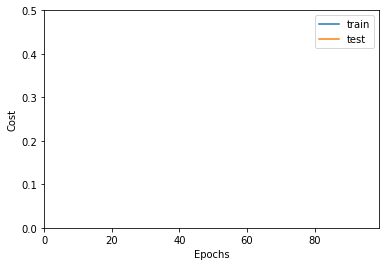

In [18]:
plt.plot(learning_curves["epochs"], learning_curves["cost_train"], label="train")
plt.plot(learning_curves["epochs"], learning_curves["cost_test"], label="test")
plt.ylabel('Cost')
plt.xlabel('Epochs')
xmax = learning_curves["epochs"][-1]
plt.axis([0,xmax,0.0,0.5])
plt.legend()
plt.show()

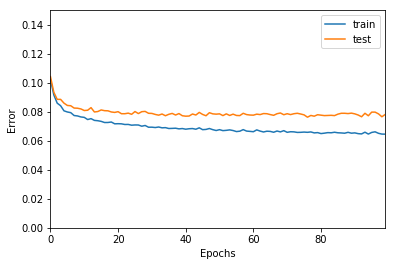

0.0646
0.0763


In [19]:
plt.plot(learning_curves["epochs"], learning_curves["error_train"], label="train")
plt.plot(learning_curves["epochs"], learning_curves["error_test"], label="test")
plt.ylabel('Error')
plt.xlabel('Epochs')
xmax = learning_curves["epochs"][-1]
plt.axis([0,xmax,0.00,0.15])
plt.legend()
plt.show()
print(np.min(learning_curves["error_train"]))
print(np.min(learning_curves["error_test"]))

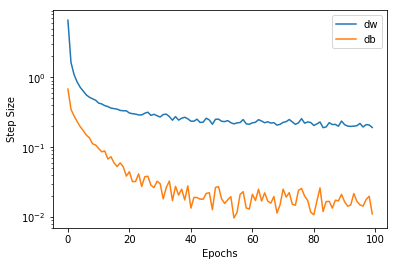

In [20]:
plt.semilogy(learning_curves["epochs"], learning_curves["step_w"], label="dw")
plt.semilogy(learning_curves["epochs"], learning_curves["step_b"], label="db")
plt.ylabel('Step Size')
plt.xlabel('Epochs')
xmax = learning_curves["epochs"][-1]
#plt.axis([0,xmax,0.00001,0.2])
plt.legend()
plt.show()

#### Plot the Misclassified Images

782
[[5 9 9 9 3 7 8 5 1 7 9 2 8 5 7]]
[3 7 4 4 8 9 1 8 8 2 7 3 3 8 9]


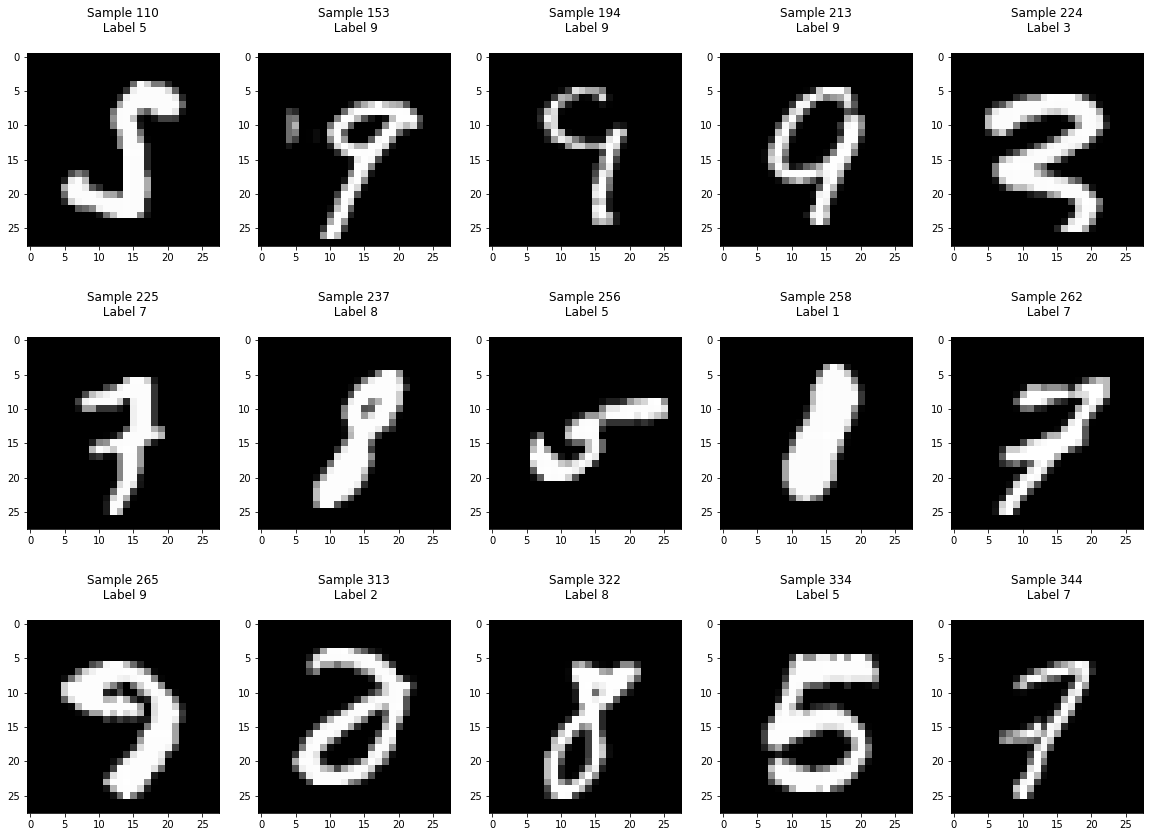

In [21]:
y_pred = predict(params['w'], params['b'], x_test)
yhat = np.argmax(y_pred, axis=0)
indices = np.where(yhat!=y_test)[1]
print(len(indices))

plot_digits(x_test, y_test, indices[10:25])
print(y_test[:,indices[10:25]])
print(yhat[indices[10:25]])

### Plot the Trained Weights as 8x8 Image 

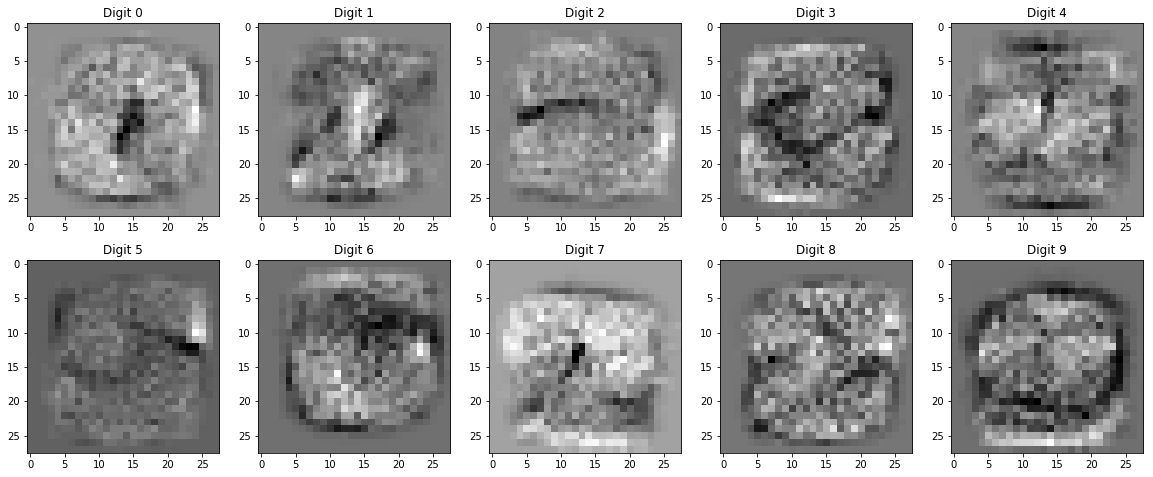

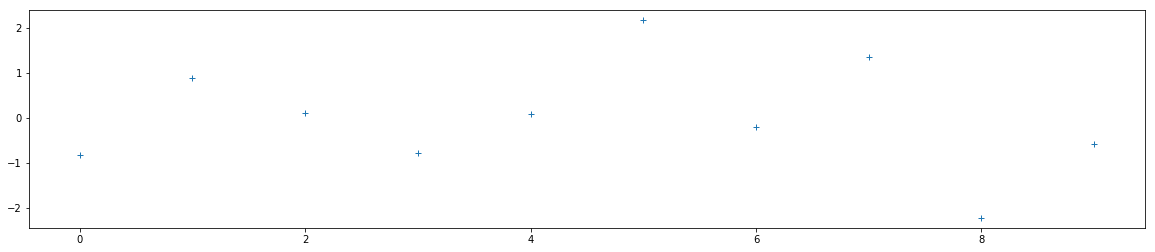

In [22]:
weights = params['w']
biases = params['b']
cols = 5
rows = 2
plt.figure(figsize=(20,4*rows))
for i in range(10):
    plt.subplot(rows, cols, i+1)
    plt.imshow(np.reshape(weights[i], (28,28)), cmap=plt.cm.gray)
    plt.title('Digit %i'%i, fontsize = 12)

plt.figure(figsize=(20,4))
plt.plot(range(10), [biases[i] for i in range(10)], '+')


In [23]:
W = params['w']
b = params['b']
y_pred = predict(W,b,x_test)
errorrates = []
errtotal = 0.0
count = 0
for digit in range(10):
    mask = np.where(y_test[0]==digit)[0]
    y_test_digit = y_test[0,mask]
    x_test_digit = x_test[:,mask]
    y_pred_digit = y_pred[:,mask]
    lendigit = x_test_digit.shape[1]
    rate = error_rate(y_pred_digit, y_test_digit)
    errorrates.append(rate)
    errtotal += rate*lendigit
    count += lendigit
    print(digit, rate, lendigit, rate*lendigit)
print(errtotal/x_test.shape[1], count) 

0 0.03311965811965812 936 31.0
1 0.0352536543422184 1163 41.0
2 0.09674134419551934 982 95.0
3 0.10886319845857419 1038 113.0
4 0.06856540084388185 948 65.0
5 0.13680781758957655 921 126.0
6 0.034550839091806514 1013 35.0
7 0.06997084548104957 1029 72.0
8 0.11349693251533742 978 111.0
9 0.09375 992 93.0
0.0782 10000


[-1, 10, 0.0, 0.2]

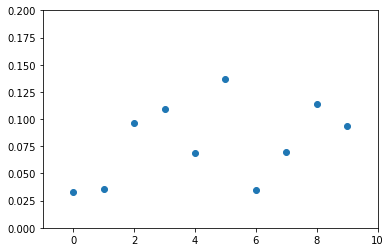

In [24]:
targets = range(10)
plt.plot(targets, errorrates,"o")
plt.axis([-1,10,0.0,0.2])